In [6]:
# Imports
import numpy as np
from scipy.integrate import solve_ivp
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib import animation
import easygui as eg

In [7]:
params = eg.multenterbox("Enter simulation params",
                         fields=["dt [micro seconds], primary source of runtime for redering animation",
                                 "total time [milli seconds]", "dz [microns], primary source of runtime for solve_ivp"],
                         values=[1, 1, 100])
# Set up simulation params. 
"""Time step size and total time is primary source of runtime for rendering animation"""
dt = float(params[0]) * 1e-6 # time step size, seconds
t0 = 0.0
tf = float(params[1]) * 1e-3 # total time evolution, seconds
t_eval = np.arange(t0, tf, dt)

"""Wire step size is primary source of runtime for solve_ivp"""
dz = float(params[2]) * 1e-6 # wire step size, meters

# Define initial conditions of detector
""" 
Defaults source:
https://www.tribology-abc.com/calculators/properties_of_common_spring_materials.pdf <-- ASTM A228
https://optimumspring.com/technical_resources/materials/carbon_steels/music_wire_228_spring_wire.aspx <-- For mass density 
"""
params = eg.multenterbox("Enter wire params", 
                         fields=["Length [m]", "Mass Density [kg / m^3]", "Tensile strength [MPa]", "Youngs Modulus [GPa]", "Wire Diameter [mm]"],
                         values=[2, 7850, 2751, 207, 0.004])
l = float(params[0]) # length of wire, meters
rho = float(params[1]) # mass density, kg/m^3
tensile_str = float(params[2]) * 10**6 # Tensile Strength of wire, Pa
young_mod = float(params[3]) * 10**9 # elastic modulus of wire, Pa
dia = float(params[4]) * 10**-3 # diameter of wire, meters
cs_area = np.pi * dia**2 / 4 # cross sectional area of wire, m^2

mu = rho * cs_area # linear mass density, kg/m
tension = 0.1 * tensile_str * cs_area # Tension on wire, N
v_press = np.sqrt(young_mod / rho) # wavespeed for longitudinal wave, m/s
v_shear = np.sqrt(tension / mu) # wavespeed for transverse waves, m/s

wire_props = (f"Length {l:.2e} m || pressure wave speed {v_press:1.2e} m/s || shear wave speed {v_shear:.2e}")
# Impact conditions of particle and track
# TODO: Make 0 custom option
relativistic = (3e8, 1.782e-24) # c [m/s], 1 TeV/c^2 [kg]
thermal_neut = (1919.62, 1.674e-27) # [m/s], [kg] --> T = 298 K, mv^2 = (3/2) k_b T
gal_orbit = (220e3, 1.782e-24) # [m/s], 1 TeV/c^2 [kg]
parts = [None, relativistic, thermal_neut, gal_orbit]
ret = eg.integerbox("Which particle?\n0: Custom\n1: Relativistic DM\n2: Thermal Neutron\n3: Galactic Orbit DM",
                    default=1, lowerbound=0, upperbound=3)
titles = ["Custom", "Relativistic DM", "Thermal Neutron", "Galactic Orbit DM"]
title_label = titles[ret]
if ret == 0:
    custom= eg.multenterbox("Enter custom particle params",
                             fields=["Mass, [kg]", "Speed, [m/s]"],
                             values=[1,1])
    parts[0] = (float(custom[1]), float(custom[0]))
G = 6.67430e-11 # gravitational constant
M = parts[ret][1] # mass of inciting particle, meters/second
v_p = parts[ret][0] # velocity of inciting particle, meters / second


params = eg.multenterbox("Enter impact params", 
                         fields=["z0 (track/wire 'intersection') [m]", "b (dist. of closest approach) [m]", "theta (angle between track and wire) [degrees]", "phi (rot. about wire) [degrees] NOT IMPLEMENTED"],
                         values=[l/4, 0.05, 45, 90])
# TODO: Integrate phi and rotations
z0 = float(params[0]) # position of particle track and wire 'intersection', meters
b = float(params[1]) # shortest distance between wire and particle track, meters
theta = float(params[2]) * (np.pi / 180) # Angle between particle track and z (wire) axes, radians
phi = float(params[3]) * (np.pi / 180) # Angle between particle track and x axes, radians
zwire = np.arange(0 - z0, l - z0, dz) # define wire along z axes s.t. z0 is at z_string == 0
v_0 = 2 * G * M / (v_p * (b**2 + (zwire * np.sin(theta))**2)) # shared component of initial velocities
bf = ('%.1E' % np.abs(v_0.max()))[4:]
balance_factor = 10**-int(bf) # Prevent IEEE imprecesion.
v_0 = v_0 * balance_factor
impact_props = (f"wire 'intersection' {z0:.2e} m || minimum distance {b:.2e} m \n"
                f"theta (track polar angle) {theta * 180 / np.pi :.2e} degrees || phi (track azimuthal(?) angle) {theta * 180 / np.pi :.2e} degrees")


In [28]:
# Define needed functions
arr_dim = zwire.size
laplacian = sparse.diags([1, -2, 1], [-1, 0, 1], shape= (arr_dim, arr_dim)) / dz**2
disp_0 = np.zeros(arr_dim) # initial displacement as function of z

def couple_fun_shear(t, u):
    """" 
    Function that returns first derivative in time for a coupled function of position and velocity 
    First arr_dim points return velocity: second arr_dim points of u
    Second arr_dim points return accelleration: v_p^2 * Laplacian.[first arr_dim points of u]
    """
    u[0] = 0 # fixed ends
    u[arr_dim - 1] = 0 #fixed ends
    du = np.zeros(2 * arr_dim) 
    # velocity is second half of coupled array (u)
    du[:arr_dim] = u[arr_dim:] 
    du[0] = 0 # fixed ends
    du[arr_dim - 1] = 0 # fixed ends
    # acceleration is wave eq on first half of coupled array (u)
    du[arr_dim:] = v_shear**2 * laplacian.dot(u[:arr_dim]) 
    du[arr_dim] = 0 # fixed ends
    du[-1] = 0 # fixed end
    return du

def couple_fun_press(t, u):
    """" 
    Function that returns first derivative in time for a coupled function of position and velocity 
    First arr_dim points return velocity: second arr_dim points of u
    Second arr_dim points return accelleration: v_p^2 * Laplacian.[first arr_dim points of u]
    """
    u[0] = 0 # fixed ends
    u[arr_dim - 1] = 0 #fixed ends
    du = np.zeros(2 * arr_dim) 
    # velocity is second half of coupled array (u)
    du[:arr_dim] = u[arr_dim:] 
    du[0] = 0 # fixed ends
    du[arr_dim - 1] = 0 # fixed ends
    # acceleration is wave eq on first half of coupled array (u)
    du[arr_dim:] = v_press**2 * laplacian.dot(u[:arr_dim]) 
    du[arr_dim] = 0 # fixed ends
    du[-1] = 0 # fixed end
    return du

def accell(t, sol):
    """
    Take solve_ivp coupled solution and a given time and return acceleration using 
    finite difference favouring symmetric difference (first and last frame use
    increasing and decreasing difference respectively)
    """
    d = 2
    if t == 0:
        less_dt = sol.y[arr_dim:, t]
        d = 1
    else:
        less_dt = sol.y[arr_dim:, t - 1]
    if t == len(sol.t) - 1:
        more_dt = sol.y[arr_dim:, t]
        d = 1
    else:
        more_dt = sol.y[arr_dim:, t + 1]  
    return (more_dt - less_dt) / (d * dt)

# def rotation matrix about z axes?

def arraymax(fun_t, t_range):
    """Return max magnitude of f(t) over range t by finding maximum of f(t).max() for each t"""
    return np.array([np.abs(fun_t[:,t]).max() for t in t_range]).max()

def arraymax2(fun_t, t_range):
    """Return max magnitude of f(t) over range t by finding mean of f(t).max() for each t"""
    return np.array([np.abs(fun_t[:,t]).max() for t in t_range]).mean()

def graph_func(t_vals, x_acc, y_acc, z_acc, z_t):
    # Animation
    fig1, (ax1, ax2, ax3) = plt.subplots(3,1)
    ax1.set_xlabel('String position [m]')
    title = ax1.set_title(' ')
    line1, = ax1.plot([], [], label='Displacement')
    line2, = ax2.plot([], [], label='Velocity')
    line3, = ax3.plot([], [], label='Acceleration')

    # multiply maximums by 1.1 to give a little padding
    t_range = range(len(t_vals))
    x_max = arraymax2(x_acc, t_range) * 1.1
    y_max = arraymax2(y_acc, t_range) * 1.1
    z_max = arraymax2(z_acc, t_range) * 1.1
    
    # Plot accerlations
    ax1.plot(t_vals, x_acc[z_t, :])
    ax2.plot(t_vals, y_acc[z_t, :])
    ax3.plot(t_vals, z_acc[z_t, :])
    # Graph aesthetics
    ax1.set_ylim(-x_max, x_max)
    ax1.set_xlim(0, tf)
    ax1.set_title('x acceleration')
    ax1.set_ylabel(f'Acceleration [m / s^2 * 10^{bf}]')

    ax2.set_ylim(-y_max, y_max)
    ax2.set_xlim(0, tf)
    ax2.set_title('y acceleration')
    ax2.set_ylabel(f'Acceleration [m/s * 10^{bf}]')

    ax3.set_ylim(-z_max, z_max)
    ax3.set_xlim(0, tf)
    ax3.set_title('z acceleration')
    ax3.set_ylabel('Acceleration [m/s^2 * 10^{bf}]')

    fig1.text(0.5,-.1, s = f"Wire Properties: {wire_props}\nImpact Properties: {impact_props}", ha='center')
    fig1.suptitle(f'Accelerations on wire at {zwire[z_t]:.3e} over {tf:.3e} seconds')
    fig1.tight_layout()
    fig1.set_figwidth(10)
    fig1.set_figheight(8)
    fig1.show()
    return fig1


In [9]:
# z axes wave 
v_z = - v_0 * zwire * np.sin(theta)**2
# Initialize coupled array
u_0 = np.zeros(2*arr_dim)
u_0[:arr_dim] = disp_0
u_0[arr_dim:] = v_z

sol = solve_ivp(couple_fun_press, t_span= [t0, tf], y0= u_0, t_eval= t_eval, method="RK23")

t_range = range(len(sol.t))
z_celerations = np.array([accell(t, sol) for t in t_range]).transpose()

In [11]:
# y axes wave
v_y = - v_0 * zwire * np.cos(theta) * np.sin(theta)
# Initialize coupled array
u_0 = np.zeros(2*arr_dim)
u_0[:arr_dim] = disp_0
u_0[arr_dim:] = v_y

sol = solve_ivp(couple_fun_shear, t_span= [t0, tf], y0= u_0, t_eval= t_eval, method="RK23")
y_celerations = np.array([accell(t, sol) for t in t_range]).transpose()

In [13]:
# x axes wave 
v_x = v_0 * b
# Initialize coupled array
u_0 = np.zeros(2*arr_dim)
u_0[:arr_dim] = disp_0
u_0[arr_dim:] = v_x

sol = solve_ivp(couple_fun_shear, t_span= [t0, tf], y0= u_0, t_eval= t_eval, method="RK23")

t_range = range(len(sol.t))
x_celerations = np.array([accell(t, sol) for t in t_range]).transpose()

C:\Users\Thomas\AppData\Local\Temp\ipykernel_9996\1733262279.py:108: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


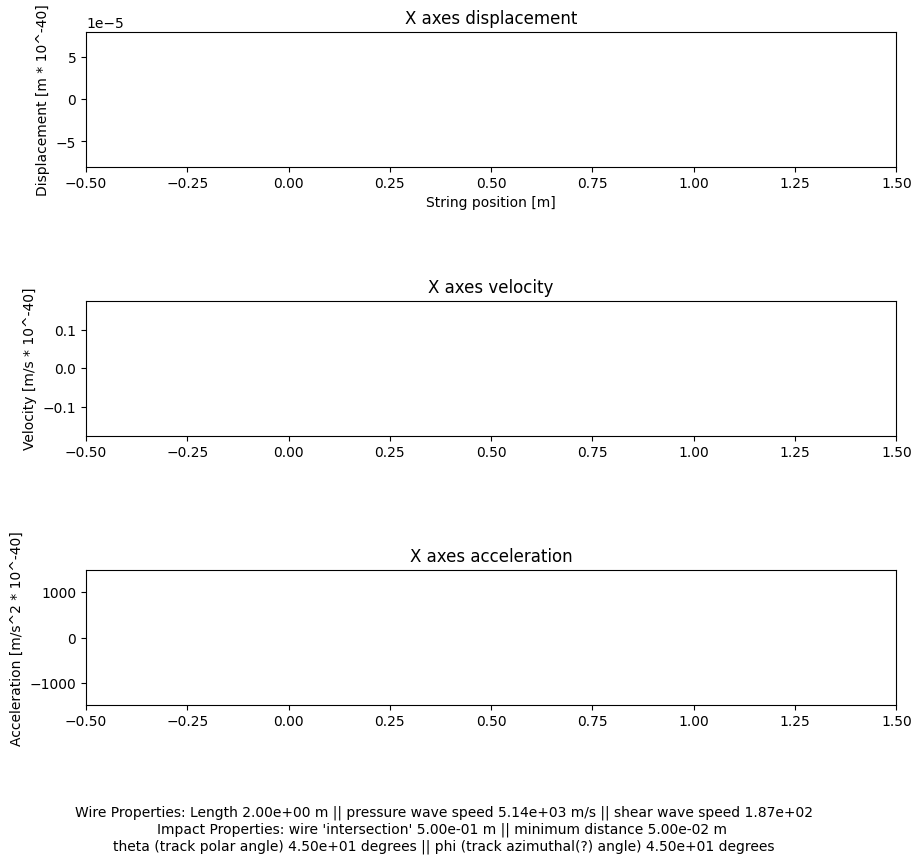

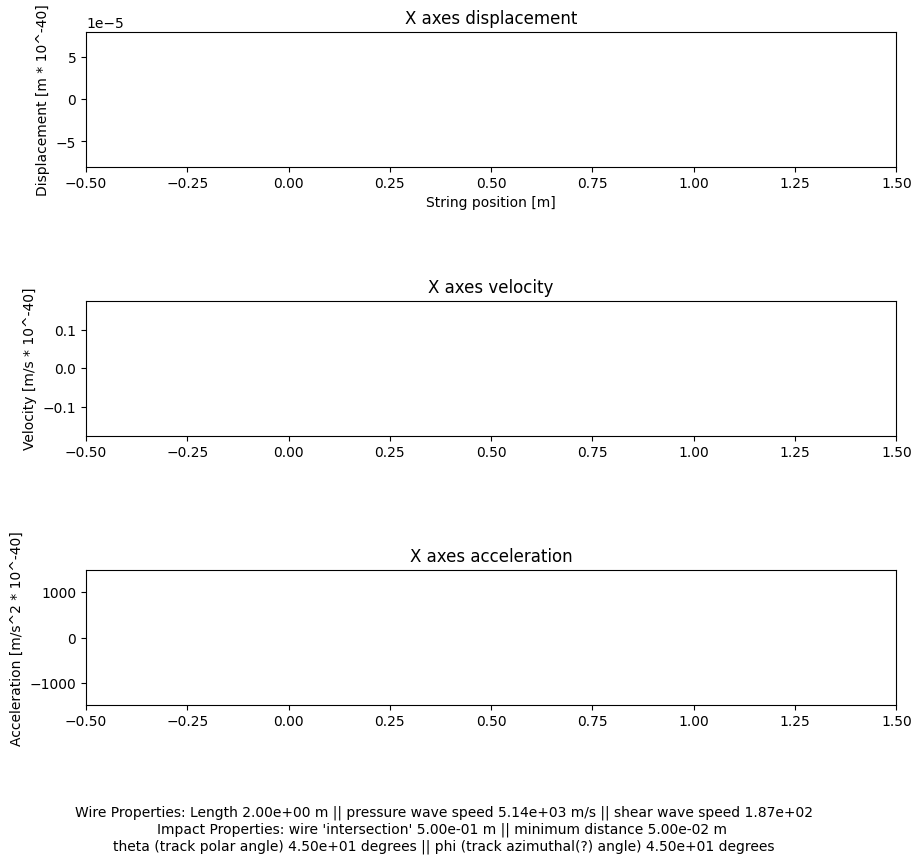

In [14]:
#Plot
graph_func(sol.t, x_celerations, y_celerations, z_celerations, arr_dim // 8)